In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 10.9 MB/s eta 0:00:00


In [3]:
import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing the Data

In [5]:
# Loading the path to the folder
DATA_PATH = "/content/drive/MyDrive/studia/Inżynierka/MAIN/"

In [6]:
# Delete the data
del data

NameError: name 'data' is not defined

In [7]:
# Loading the prepared dataset
data = pd.read_csv(DATA_PATH + 'PreparedDataset.csv', low_memory=False)
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
print(data.info())
# Speccify the ticker
ticker = 'FERG'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  3481 non-null   datetime64[ns, UTC]
 1   Close     3481 non-null   float64            
 2   Returns   3481 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 81.7 KB
None



Be careful! Check if the Returns values were properly loaded for the PreparedDataset.csv

In [8]:
# check the current ticker
ticker

'FERG'

In [9]:
# check the data
data

,Datetime,Close,Returns
0,2022-12-12 17:30:00+00:00,127.150002,-0.28
1,2022-12-12 18:30:00+00:00,127.739998,0.46
2,2022-12-12 19:30:00+00:00,128.794998,0.83
3,2022-12-12 20:30:00+00:00,128.690002,-0.08
4,2022-12-13 14:30:00+00:00,132.255005,2.77
...,...,...,...
3476,2024-12-06 16:30:00+00:00,216.750000,0.16
3477,2024-12-06 17:30:00+00:00,217.059998,0.14
3478,2024-12-06 18:30:00+00:00,216.720001,-0.16
3479,2024-12-06 19:30:00+00:00,216.550003,-0.08


# Analysis of ARIMA-GARCH Model

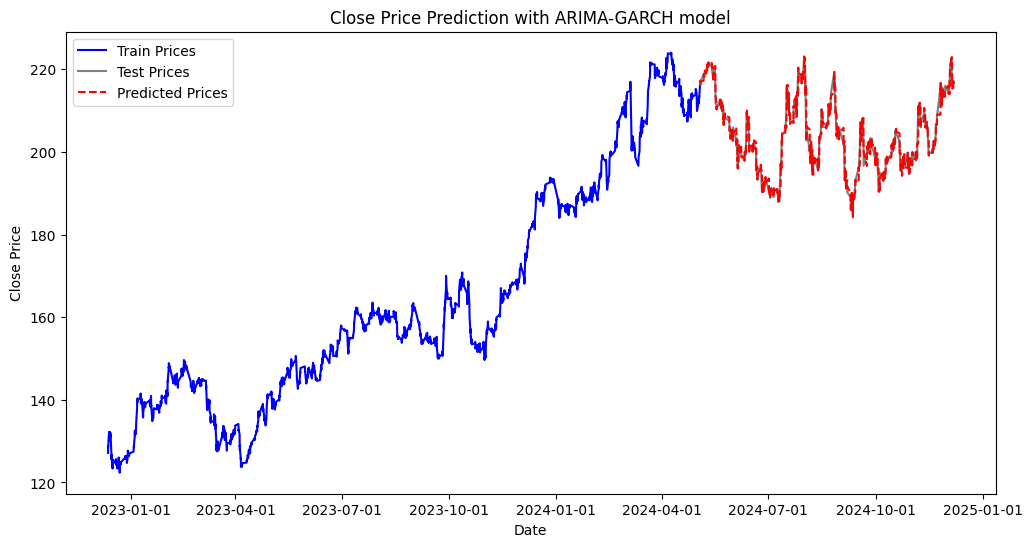

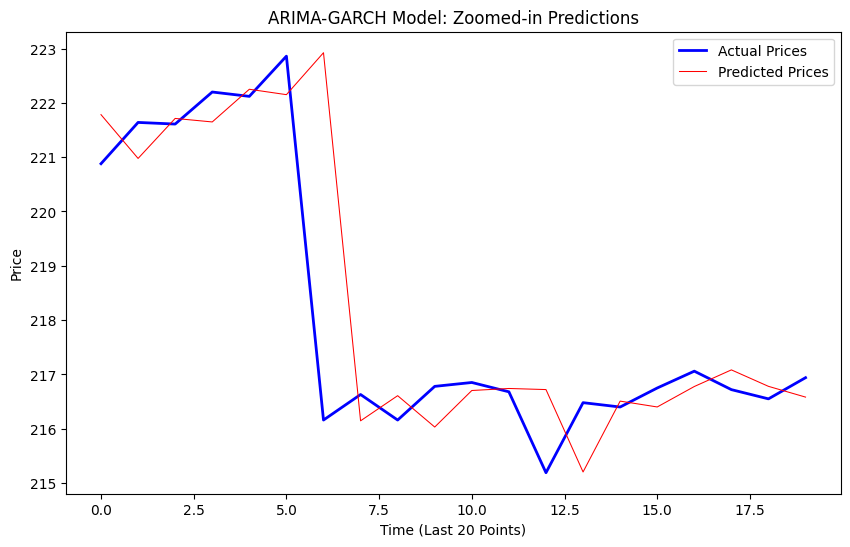

Mean Squared Error (MSE): 1.888529401240769
Root Mean Squared Error (RMSE): 1.37
Mean Absolute Error (MAE): 0.81
Mean Absolute Percentage Error (MAPE): 0.4
Saving model to /content/drive/MyDrive/studia/Inżynierka/MAIN/trained_st/ARIMA-GARCH_FERG_arima-5_1_0_garch-1_1_mse-1.88853.ckpt
Model successfully saved to /content/drive/MyDrive/studia/Inżynierka/MAIN/trained_st/ARIMA-GARCH_FERG_arima-5_1_0_garch-1_1_mse-1.88853.ckpt


In [11]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare the data
prices = data[['Datetime', 'Close']]
prices = prices.set_index('Datetime')
returns = data['Returns']

# Train and Test data
train_size = int(len(returns) * 0.7)
train_prices = prices[:train_size]
test_prices = prices[train_size:]

# ARIMA parameters
p, d, q = 5, 1, 0

# Initialize the variables
history_prices = train_prices['Close'].tolist()
combined_predictions = []

# Fit ARIMA on the historical prices
arima_model = ARIMA(history_prices, order=(p, d, q))
arima_fit = arima_model.fit()

# Rolling forecast with ARIMA-GARCH
for t in range(len(test_prices)):

    # ARIMA forecast of the next value
    arima_forecast = arima_fit.forecast()

    # Calculate residuals from ARIMA model
    arima_residuals = arima_fit.resid

    # Fit GARCH on ARIMA residuals
    garch_model = arch_model(arima_residuals, vol='GARCH', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')

    # Forecast volatility (next residual)
    garch_forecast = garch_fit.forecast(horizon=1)
    predicted_residual = garch_forecast.mean.values[-1, 0]

    # Combine ARIMA forecast and GARCH residual
    combined_forecast = arima_forecast[0] + predicted_residual
    combined_predictions.append(combined_forecast)

    # Update history with the actual price
    arima_fit = arima_fit.append([test_prices['Close'].iloc[t]], refit=False)
    history_prices.append(test_prices['Close'].iloc[t])

# Convert predictions to a pandas Series
combined_predictions = pd.Series(combined_predictions, index=test_prices.index)

# Plot the trained, tested, and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(train_prices.index, train_prices['Close'], label='Train Prices', color="blue")
plt.plot(test_prices.index, test_prices['Close'], label='Test Prices', color="grey")
plt.plot(test_prices.index, combined_predictions, label='Predicted Prices', color='red', linestyle='--')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Prediction with ARIMA-GARCH model')
plt.legend()
plt.show()

# Zoom the Prediction
plt.figure(figsize=(10, 6))

# Specify the number of data points to zoom into
zoom_range = 20
# Plot last data points of test prices and predictions
plt.plot(np.arange(zoom_range), test_prices['Close'][-zoom_range:].values, 'b', label="Actual Prices", linewidth=2)
plt.plot(np.arange(zoom_range), combined_predictions[-zoom_range:].values, 'r', label="Predicted Prices", linewidth=0.75)

plt.title("ARIMA-GARCH Model: Zoomed-in Predictions")
plt.xlabel('Time (Last 20 Points)')
plt.ylabel('Price')
plt.legend()
plt.show()

# Performance metrics
mse = mean_squared_error(test_prices['Close'], combined_predictions)
rmse = round(np.sqrt(mse), 2)
mae = round(mean_absolute_error(test_prices['Close'], combined_predictions), 2)
mape = round(np.mean(np.abs((test_prices['Close'] - combined_predictions) / test_prices['Close'])) * 100, 2)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)

# Save model to the file
output = '/content/drive/MyDrive/studia/Inżynierka/MAIN/trained_st/'

filename = os.path.join(
            output,
            f'ARIMA-GARCH_{ticker}_arima-5_1_0_garch-1_1_mse-{mse:.5f}.ckpt')

print(f'Saving model to {filename}')

with open(filename, 'wb') as file:
    pickle.dump(garch_fit, file)
print(f"Model successfully saved to {filename}")
